In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np

from covid_19 import simulate

In [2]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

# 1st wave data
start_date_1 = dt.datetime(2020, 2, 26)
end_date_1 = dt.datetime(2020, 6, 5)
diff = abs((end_date_1 - start_date_1).days)

confirmed_cases_1 = confirmed_cases[:diff+1]
recovered_cases_1 = recovered_cases[:diff+1]
death_cases_1 = death_cases[:diff+1]
removed_cases_1 = removed_cases[:diff+1]
active_cases_1 = active_cases[:diff+1]

# 2nd wave data
start_date_2 = dt.datetime(2020, 6, 6)
confirmed_cases_2 = confirmed_cases[diff+1:]
recovered_cases_2 = recovered_cases[diff+1:]
death_cases_2 = death_cases[diff+1:]
removed_cases_2 = removed_cases[diff+1:] - removed_cases[diff+1]
active_cases_2 = active_cases[diff+1:]

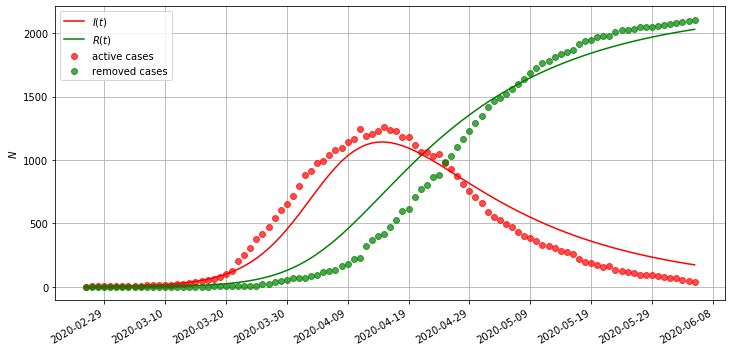

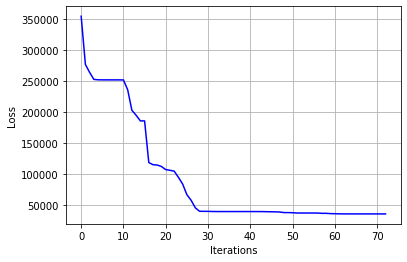

In [3]:
S0 = 2200
E0 = 3 * active_cases_1[0]
I0 = active_cases_1[0]
R0 = removed_cases_1[0]

(S, E, I, R), _, loss = simulate.seir_dynamics(
    active_cases=active_cases_1, 
    removed_cases=recovered_cases_1, 
    initial_conditions=(S0, E0, I0, R0),
    epidemics_start_date=start_date_1,
    plot_sim=True,
    plot_l=True,
)